# Test and Analyze Model Robustness with NRTK and XAITK for the Image Classification Task

## Overview
This guide demonstrates how to integrate the Natural Robustness Toolkit (NRTK) with XAITK-Saliency to assess model robustness
and understand why models fail in image classification tasks. Unlike traditional robustness testing, which only measures performance degradation, this
approach reveals how the features your model focuses on change under perturbation, allowing you to interpret and act on the
results as they are generated.

This notebook is created from [Explaining model robustness: combining saliency maps and natural robustness testing using XAITK and NRTK](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/13476/3052320/Explaining-model-robustness--combining-saliency-maps-and-natural-robustness/10.1117/12.3052320.short).

## What You'll Accomplish
- Apply systematic perturbations and generate interpretable saliency maps.
- Recognize robust vs. sensitive model behaviors as you test.
- Quantify saliency changes and understand what they indicate.
- Make informed decisions about model deployment and improvement.

## Table of Contents

* [Set Up the Environment](#set-up-the-environment)
* [Define Model and Dataset](#define-model-and-dataset)
* [Configure Your NRTK Perturbation Strategy](#configure-your-nrtk-perturbation-strategy)
    * [Gaussian Blur Perturbation](#gaussian-blur-perturbation)
    * [Salt Noise Perturbation](#salt-noise-perturbation)
* [Evaluate Perturbed Datasets](#evaluate-perturbed-datasets)
    * [Compute Accuracy Metric](#compute-accuracy-metric)
    * [Generate Item Response Curves](#generate-item-response-curves)
* [Generate and Evaluate Saliency Maps](#generate-and-evaluate-saliency-maps)
    * [Initialize RISE (with Debiasing) Saliency Method](#initialize-rise-with-debiasing-saliency-method)
    * [Compute Saliency Maps and Related Metrics](#compute-saliency-maps-and-related-metrics)
    * [Interpretability Analysis](#interpretability-analysis)
* [Conclusion](#conclusion) 

## Set Up the Environment 

In [1]:
import sys  # noqa: F401

!{sys.executable} -m pip install -qU pip
print("Installing nrtk with optional dependencies...")
!{sys.executable} -m pip install -q nrtk[pybsm,maite,tools,scikit-image,headless,notebook-testing,Pillow]
print("Install huggingface transformers and datasets")
!{sys.executable} -m pip install -q transformers datasets
print("Installing ultralytics...")
!{sys.executable} -m pip install -q ultralytics
print("Installing tabulate...")
!{sys.executable} -m pip install -q tabulate
print("Clean install of xaitk-saliency from JATIC gitlab...")
!{sys.executable} -m pip uninstall -y xaitk_saliency
!{sys.executable} -m pip install -q xaitk_saliency

Installing nrtk with optional dependencies...
Install huggingface transformers and datasets
Installing ultralytics...
Installing tabulate...
Clean install of xaitk-saliency from JATIC gitlab...
Found existing installation: xaitk-saliency 0.13.0
Uninstalling xaitk-saliency-0.13.0:
  Successfully uninstalled xaitk-saliency-0.13.0


In [2]:
from __future__ import annotations  # noqa: F404

# Python imports
import os
import random

# 3rd party imports
import matplotlib.pyplot as plt
import numpy as np
import torch

# Setting seed for reproducibility
seed = 123
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.default_rng(seed)
torch.manual_seed(seed)

%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations

## Define Model and Dataset

The NRTK-XAITK workflow depends on [HuggingFace](https://huggingface.co/) (HF) to download the required dataset/model. To align the dataset/model to the Image Classification evaluation workflow, we need to adapt the HF dataset/model to be compliant with [MAITE](https://github.com/mit-ll-ai-technology/maite) protocols. 

In the section below, we define the HuggingFace-MAITE adapters for the [EuroSAT](https://github.com/phelber/EuroSAT) dataset and HF pretrained-model for the Image Classification task.

In [3]:
from nrtk.utils.interop.image_classification.dataset import (
    HuggingFaceMaiteDataset,
    create_data_subset,
)
from nrtk.utils.interop.image_classification.model import HuggingFaceMaiteModel

# Check if CUDA is available and set the device accordingly
CUDA_AVAILABLE = torch.cuda.is_available()
device = "cuda" if CUDA_AVAILABLE else "cpu"

hf_dataset_name = "cm93/eurosat"  # Hugging Face dataset name
test_set_fraction = 0.01  # Fraction of the test set to use for the subset

# Create a subset of the EuroSAT dataset
hf_dataset = create_data_subset(
    dataset_name=hf_dataset_name,
    split="test",
    fraction=test_set_fraction,
)
# Print dataset information
print(f"Dataset name: {hf_dataset_name}")
print(f"Number of samples: {len(hf_dataset)}")
categories = hf_dataset.features["label"].names
print(f"Dataset categories: {categories}")

# Create a HuggingFaceMaiteDataset instance
# This will wrap the Hugging Face dataset to comply with the MAITE Dataset protocol
maite_dataset = HuggingFaceMaiteDataset(hf_dataset, hf_dataset_name)
print(f"Number of classes: {maite_dataset.num_classes}")

# Create a HuggingFaceMaiteModel instance
# This will wrap a Hugging Face model to comply with the MAITE Image Classification protocol
maite_classifier = HuggingFaceMaiteModel(
    model_name="nielsr/convnext-tiny-224-finetuned-eurosat-albumentations",
    device=device,
)

/home/local/KHQ/stephen.crowell/.cache/pypoetry/virtualenvs/nrtk-XgrOuMnz-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset name: cm93/eurosat
Number of samples: 27
Dataset categories: ['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']
Number of classes: 10


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Configure Your NRTK Perturbation Strategy

### Gaussian Blur Perturbation

To perturb the input dataset with the Gaussian Blur operation, we set up a sequence of perturber configurations using the ``GaussianBlurPerturber`` that ranges across five blur kernel sizes (ksize). Each perturber configuration is applied to the entire dataset to create five new perturbed datasets. To understand each perturber's setting, we visualize a sample image from each dataset.

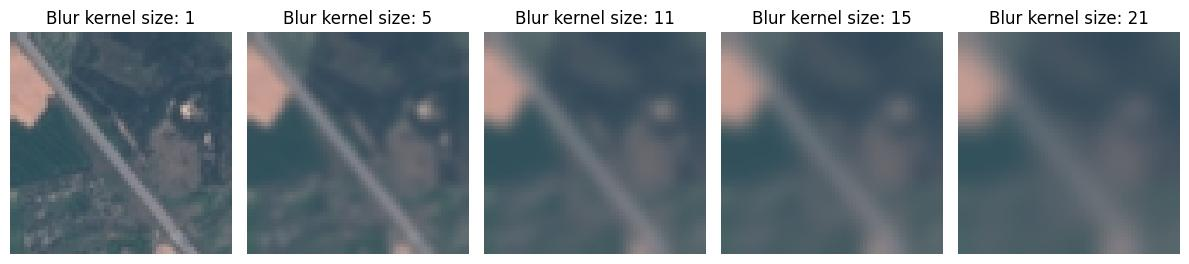

In [4]:
from nrtk.impls.perturb_image.generic.cv2.blur import GaussianBlurPerturber

# Parameters for Gaussian blur perturbation sweep
SWEEP_LOW = 1  # minimum kernel size
SWEEP_HIGH = 20  # maximum kernel size
SWEEP_COUNT = 5  # number of values to sample

# Generate list of odd kernel sizes for Gaussian blur
blur_perturbation_values = np.floor(
    np.linspace(
        SWEEP_LOW,
        SWEEP_HIGH,
        SWEEP_COUNT,
        endpoint=True,
    ),
).astype(int)
# Gaussian blur requires odd kernel sizes to maintain
# symmetric padding along the edges to preserve dimensionality.
blur_perturbation_values = [p if p % 2 == 1 else p + 1 for p in blur_perturbation_values]
blur_augmentations = [GaussianBlurPerturber(ksize=p) for p in blur_perturbation_values]

# Visualize the perturbations on a sample image
img = np.asarray(hf_dataset[9]["image"])

_, ax = plt.subplots(1, 5, figsize=(12, 6))
for idx, p in enumerate(blur_perturbation_values):
    ax[idx].set_title(f"Blur kernel size: {p}")
    ax[idx].imshow(blur_augmentations[idx](img)[0])
    _ = ax[idx].axis("off")
plt.tight_layout()

### Salt Noise Perturbation

To apply salt noise to the input dataset, we set up a sequence of perturber configurations using the ``SaltNoisePerturber`` that ranges across five salt noise amount values. Each perturber configuration is applied on the entire dataset to create five new perturbed datasets. To understand each perturber's setting, we visualize a sample image from each dataset.

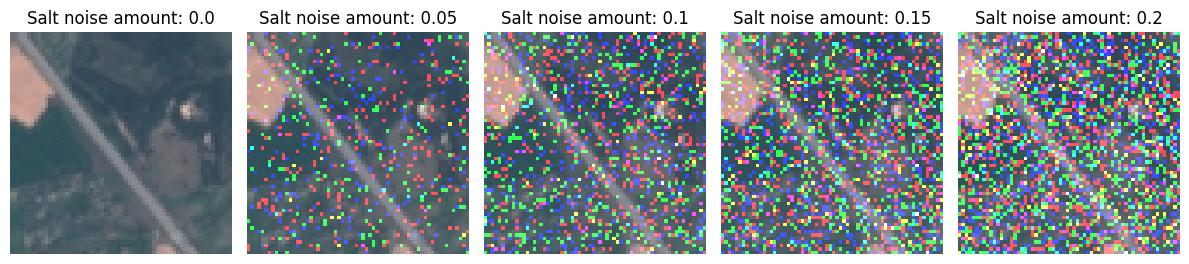

In [5]:
from nrtk.impls.perturb_image.generic.skimage.random_noise import SaltNoisePerturber

# Parameters for salt noise perturbation sweep
SWEEP_LOW = 0.0  # minimum salt noise amount
SWEEP_HIGH = 0.20  # maximum salt noise amount
SWEEP_COUNT = 5  # number of values to sample

# Generate augmentations using salt noise with increasing intensity
noise_perturbation_values = np.round(
    np.linspace(
        SWEEP_LOW,
        SWEEP_HIGH,
        SWEEP_COUNT,
        endpoint=True,
    ).astype(float),
    decimals=2,
)
salt_augmentations = [SaltNoisePerturber(amount=s) for s in noise_perturbation_values]

# Visualize the perturbations on a sample image
img = np.asarray(hf_dataset[9]["image"])

_, ax = plt.subplots(1, 5, figsize=(12, 6))
for idx, s in enumerate(noise_perturbation_values):
    ax[idx].set_title(f"Salt noise amount: {s}")
    ax[idx].imshow(salt_augmentations[idx](img)[0])
    _ = ax[idx].axis("off")
plt.tight_layout()

## Evaluate Perturbed Datasets

### Compute Accuracy Metric

For understanding the overall impact of the two different perturbers on model performance, we compute the model's prediction accuracy across the various perturbed datasets. For this computation, we use a MAITE-compliant accuracy metric and evaluation workflow. To adapt the perturber configurations within this workflow, we use NRTK's ``JATICClassificationAugmentation`` wrapper.

In [6]:
import torchmetrics.classification
from maite.interop.metrics.torchmetrics import TMClassificationMetric
from maite.tasks import evaluate

from nrtk.interop.maite.interop.image_classification.augmentation import JATICClassificationAugmentation

# Initialize accuracy metric (Maite-compatible)
classification_metric = torchmetrics.classification.MulticlassAccuracy(maite_dataset.num_classes)
maite_acc_metric = TMClassificationMetric(classification_metric)

# List to store results for Gaussian blur perturbation
gauss_blur_perturbed_metrics = []
for idx, aug in enumerate(blur_augmentations):
    # Create a JATICClassificationAugmentation instance for each perturbation
    maite_aug = JATICClassificationAugmentation(augment=aug, augment_id=f"GaussianBlurPerturber_{idx}")
    # reset the metric object for each dataset
    maite_acc_metric.reset()
    result, _, _ = evaluate(
        model=maite_classifier,
        metric=maite_acc_metric,
        dataset=maite_dataset,
        augmentation=maite_aug,
    )
    gauss_blur_perturbed_metrics.append(result)

# List to store results for Gaussian blur perturbation
salt_noise_perturbed_metrics = []
for idx, aug in enumerate(salt_augmentations):
    # Create a JATICClassificationAugmentation instance for each perturbation
    maite_aug = JATICClassificationAugmentation(augment=aug, augment_id=f"SaltNoisePerturber_{idx}")
    # reset the metric object for each dataset
    maite_acc_metric.reset()
    result, _, _ = evaluate(
        model=maite_classifier,
        metric=maite_acc_metric,
        dataset=maite_dataset,
        augmentation=maite_aug,
    )
    salt_noise_perturbed_metrics.append(result)

100%|███████████████████████████████████████████| 27/27 [00:00<00:00, 71.60it/s]


### Generate Item Response Curves

The accuracy metric values (generated above) are visualized as item-response curves to understand the robustness of the model to varying degree of Blur and Salt noise perturbations. From the plots below, we can see a sharp drop in accuracy of the model on increasing the perturbation intensity.

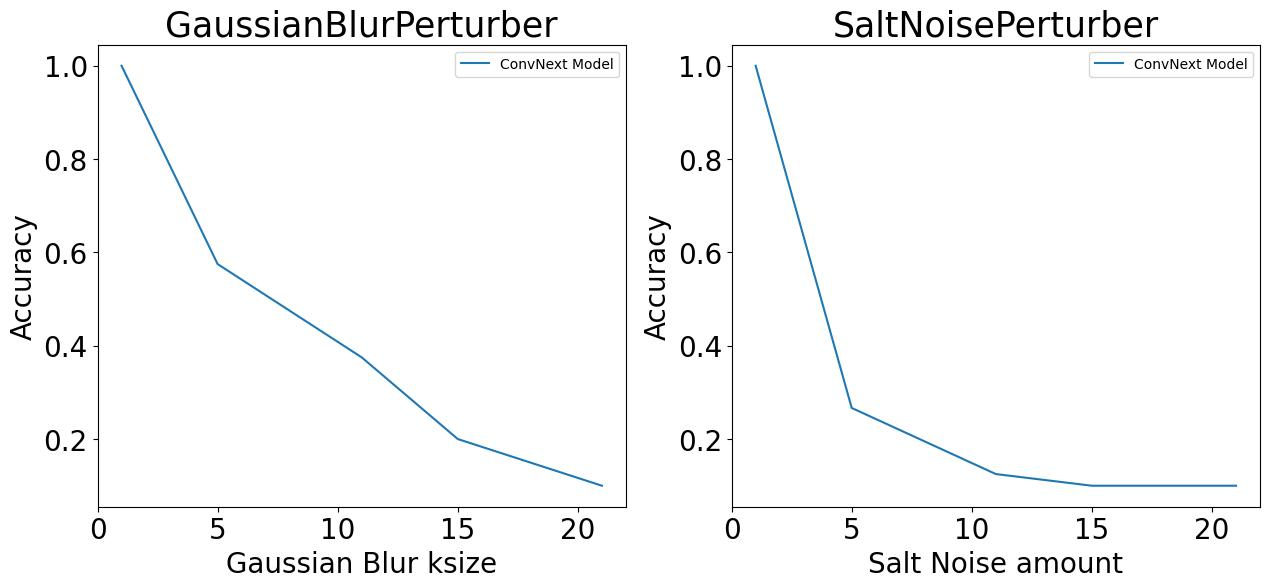

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create 1-row, 2-column grid

_ = axes[0].plot(
    blur_perturbation_values,
    [m["MulticlassAccuracy"] for m in gauss_blur_perturbed_metrics],
    label="ConvNext Model",
)
axes[0].set_title("GaussianBlurPerturber", fontsize=25)
axes[0].set_xlabel("Gaussian Blur ksize", fontsize=20)
axes[0].set_ylabel("Accuracy", fontsize=20)
axes[0].tick_params(axis="both", which="major", labelsize=20)
_ = axes[0].legend()

# Salt noise results
_ = axes[1].plot(
    blur_perturbation_values,
    [m["MulticlassAccuracy"] for m in salt_noise_perturbed_metrics],
    label="ConvNext Model",
)
axes[1].set_title("SaltNoisePerturber", fontsize=25)
axes[1].set_xlabel("Salt Noise amount", fontsize=20)
axes[1].set_ylabel("Accuracy", fontsize=20)
axes[1].tick_params(axis="both", which="major", labelsize=20)
_ = axes[1].legend()

## Generate and Evaluate Saliency Maps

### Initialize RISE (with Debiasing) Saliency Method

We initialize the RISE saliency method with debiasing along with the MAITE-compliant ``JATICImageClassifier`` wrapper for generating saliency maps based on model-inference.

In [8]:
from xaitk_jatic.interop.image_classification.model import JATICImageClassifier
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.rise import RISEStack

# Saliency prep
model_mean = [95, 96, 93]

blackbox_fill = np.uint8(np.asarray(model_mean) * 255)
gen_rise_debiased = RISEStack(n=200, s=8, p1=0.5, seed=seed, threads=4, debiased=True)
gen_rise_debiased.fill = blackbox_fill.astype(int)

# XAITK-MAITE interop model wrapper for Image Classification
jatic_classifier = JATICImageClassifier(
    classifier=maite_classifier,
    ids=sorted(maite_classifier.id2label.keys()),
    img_batch_size=1,
)

### Compute Saliency Maps and Related Metrics

#### Metric Helper/Util Functions

First, we set up the XAITK-Saliency metric helper/utility functions.

In [9]:
from dataclasses import dataclass, field

from xaitk_saliency.impls.saliency_metric.entropy import Entropy
from xaitk_saliency.utils.sal_metrics import (
    compute_ssd,
    compute_xcorr,
)


@dataclass
class PerturbationResult:
    """Dataclass for storing perturbed image and associated results."""

    descriptor: str
    img: np.ndarray
    sal_maps: np.ndarray
    pred_class: int
    pred_prob: float


@dataclass
class SaliencyResults:
    """Dataclass for storing saliency map and associated results."""

    ref_img: np.ndarray
    ref_sal_maps: np.ndarray
    gt: int
    pred_class: int
    pred_prob: float
    perturbations: list[PerturbationResult] = field(default_factory=list)


def _compute_entropy_setup(sal_map: np.ndarray, m: str) -> float:
    if m == "entropy":
        compute_entropy = Entropy()
        return compute_entropy(sal_map)
    if m == "pos saliency entropy":
        compute_entropy = Entropy(clip_range=(0, 1))
        return compute_entropy(sal_map)
    if m == "neg saliency entropy":
        compute_entropy = Entropy(clip_range=(-1, 0))
        return compute_entropy(sal_map)
    return np.nan


def _compute_metric(sal_map: np.ndarray, ref_sal_map: np.ndarray, m: str) -> float | np.float64:
    if "entropy" in m:
        return _compute_entropy_setup(sal_map, m)
    if m == "ssd":
        return compute_ssd(sal_map, ref_sal_map)
    if m == "xcorr":
        return compute_xcorr(sal_map, ref_sal_map)
    return np.nan

#### Saliency Generation

Following the metric utils setup, we loop through both the ``GaussianBlurPerturber`` and ``SaltNoisePerturber`` perturbed datasets to generate predictions, compute saliency maps, and compute the related metric values.

In [ ]:
import pandas as pd

# Initialize results dictionary to store all results
results_dict = dict()
model_dict = dict()

metrics_df = pd.DataFrame(
    columns=["perturb_config", "image_id", "gt_label", "confidences", "entropy", "ssd", "xcorr"],
)

for transform in blur_augmentations + salt_augmentations:
    perturbation_type = transform.__class__.__name__
    perturb_param_name = "ksize" if perturbation_type == "GaussianBlurPerturber" else "amount"
    perturb_param_val = transform.ksize if perturbation_type == "GaussianBlurPerturber" else transform.amount  # type: ignore[union-attr]

    perturb_key = f"{perturbation_type}_{perturb_param_name}_{perturb_param_val}"

    # Initialize tracking lists for results
    model_dict[perturb_key] = dict()
    perturbed_images: list[np.ndarray] = list()
    sal_maps: list[np.ndarray] = list()
    truth_labels: list[str] = list()
    truth_scores: list[float] = list()
    pred_labels: list[str] = list()
    pred_scores: list[float] = list()
    perturb_values: list[float] = list()

    # For visualization, grab transform without normalizing and perform tensor conversion
    for i in range(len(maite_dataset)):
        # Load in image and ground truth label
        ref_image, label, metadata = maite_dataset[i]
        ref_image = np.asarray(ref_image)

        class_idx = np.argmax(label)
        truth_label = categories[np.argmax(label)]

        # Tranform image with perturbation and extract features + preds
        ref_image = ref_image.transpose(1, 2, 0)
        trans_img = transform(ref_image)[0]
        trans_img = trans_img.transpose(2, 0, 1)

        logits = maite_classifier.extract_features([trans_img])
        prediction = torch.nn.functional.softmax(logits, dim=1)

        # Format output and ground truth into proper format
        prediction = prediction.cpu().detach().numpy() if logits.requires_grad else prediction.cpu().numpy()

        pred_idx = np.argmax(prediction[0])
        prediction_label = categories[pred_idx]

        prediction_score = prediction[0][pred_idx]
        truth_score = prediction[0][class_idx]

        class_labels = [truth_label, prediction_label]
        class_ids = [class_idx, pred_idx]

        # Run saliency on predictions
        sal_map = gen_rise_debiased(trans_img.transpose(1, 2, 0), jatic_classifier)

        # Compute saliency metrics
        ssd = round(_compute_metric(sal_map[0], sal_map[1], "ssd"), ndigits=5)
        xcorr = round(_compute_metric(sal_map[0], sal_map[1], "xcorr"), ndigits=5)
        entropy = round(
            _compute_metric(sal_map[0], sal_map[1], "entropy"),
            ndigits=5,
        )

        preds = prediction[0].round(decimals=5).tolist()
        metrics_df.loc[len(metrics_df)] = [perturb_key, i, class_idx, preds, entropy, ssd, xcorr]
        perturbed_images.append(trans_img.transpose(1, 2, 0))
        sal_maps.append(sal_map)
        truth_labels.append(truth_label)
        truth_scores.append(truth_score)
        pred_labels.append(prediction_label)
        pred_scores.append(prediction_score)
        perturb_values.append(perturb_param_val)

    print(perturb_key)
    model_dict[perturb_key]["perturbed_images"] = perturbed_images
    model_dict[perturb_key]["sal_maps"] = sal_maps
    model_dict[perturb_key]["truth_labels"] = truth_labels
    model_dict[perturb_key]["truth_scores"] = truth_scores
    model_dict[perturb_key]["pred_labels"] = pred_labels
    model_dict[perturb_key]["pred_scores"] = pred_scores
    model_dict[perturb_key]["perturb_values"] = perturb_values

model_backbone = maite_classifier.model_name.split("/")[-1].split("-")[0]
results_dict[f"{model_backbone}"] = model_dict

GaussianBlurPerturber_ksize_1
GaussianBlurPerturber_ksize_5
GaussianBlurPerturber_ksize_11
GaussianBlurPerturber_ksize_15
GaussianBlurPerturber_ksize_21
SaltNoisePerturber_amount_0.0
SaltNoisePerturber_amount_0.05
SaltNoisePerturber_amount_0.1
SaltNoisePerturber_amount_0.15


### Interpretability Analysis

#### Visualization Helper Function

This is the helper function to organize the output into a plot with the input image, ground truth (GT) saliency map, and predicted saliency map displayed side by side.

In [ ]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure


def visualize_saliency(  # noqa: C901
    pert_images: list[np.ndarray],
    truth_labels: list[str],
    sal_maps_1: list[np.ndarray],
    truth_scores_1: list[float],
    pred_labels_1: list[str],
    pred_scores_1: list[float],
    perturb_param: str,
    perturb_values: list[float],
) -> tuple[Figure, list[Axes]]:
    """Visualize reference image and corresponding saliency maps.

    This function creates the visualization for the NRTK-XAITK quick task.
    It has three columns: a perturbed image, the saliency with respect to the true
    class, and the saliency with respect to the predicted class.
    This is repeated for the variable number of perturbations provided. For the quick task,
    the first 'perturbation' was the unperturbed, baseline image. All arguments are lists

    Returns:
        tuple: (figure object, list of axis objects)
    """
    # Determine layout dimensions
    n_cols = 3
    n_rows = len(sal_maps_1)

    fontsize = 20
    fontdiff = 4

    # Create figure and axes grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))

    axes = axes.flatten()
    for (
        perturb_index,
        pert_image,
        truth_label,
        sal_map_1,
        truth_score_1,
        pred_label_1,
        pred_score_1,
        perturb_value,
    ) in zip(
        range(n_rows),
        pert_images,
        truth_labels,
        sal_maps_1,
        truth_scores_1,
        pred_labels_1,
        pred_scores_1,
        perturb_values,
    ):
        base_ind = perturb_index * n_cols
        for spine in axes[base_ind].spines.values():
            spine.set_visible(False)
        axes[base_ind].imshow(pert_image)
        axes[base_ind].set_xticks([])
        axes[base_ind].set_yticks([])
        if perturb_index == 0:
            axes[base_ind].text(
                0.5,
                1.1,
                "Perturb Value",
                transform=axes[base_ind].transAxes,
                ha="center",
                va="bottom",
                fontsize=fontsize,
                fontweight="bold",
            )
        axes[base_ind].text(
            0.5,
            0.99,
            f"{perturb_param}: {round(perturb_value, ndigits=2)}",
            transform=axes[base_ind].transAxes,
            ha="center",
            va="bottom",
            fontsize=fontsize - fontdiff,
            fontweight="bold",
        )
        axes[base_ind + 1].set_axis_off()

        color_1 = "green" if truth_label == pred_label_1 else "red"

        # Plot saliency maps
        truth_pos_map_1 = np.clip(sal_map_1[0], 0, 1)
        pred_pos_map_1 = np.clip(sal_map_1[1], 0, 1)

        # Saliency of GT label
        axes[base_ind + 1].imshow(pert_image, alpha=0.7)
        axes[base_ind + 1].imshow(truth_pos_map_1, cmap="jet", alpha=0.3, vmin=0, vmax=1)
        if perturb_index == 0:
            axes[base_ind + 1].text(
                0.5,
                1.3,
                "ConvNext Model",
                transform=axes[base_ind + 1].transAxes,
                ha="center",
                va="bottom",
                fontsize=fontsize,
                fontweight="bold",
            )
            axes[base_ind + 1].text(
                0.5,
                1.1,
                "Truth",
                transform=axes[base_ind + 1].transAxes,
                ha="center",
                va="bottom",
                fontsize=fontsize,
                fontweight="bold",
            )
        axes[base_ind + 1].text(
            0.5,
            0.99,
            f"{truth_label}: {truth_score_1:.2f}",
            transform=axes[base_ind + 1].transAxes,
            ha="center",
            va="bottom",
            fontsize=fontsize - fontdiff,
            fontweight="bold",
        )

        # Saliency of predicted label
        axes[base_ind + 2].set_axis_off()
        axes[base_ind + 2].imshow(pert_image, alpha=0.7)
        axes[base_ind + 2].imshow(pred_pos_map_1, cmap="jet", alpha=0.3, vmin=0, vmax=1)
        if perturb_index == 0:
            axes[base_ind + 2].text(
                0.5,
                1.1,
                "Prediction",
                transform=axes[base_ind + 2].transAxes,
                ha="center",
                va="bottom",
                fontsize=fontsize,
                fontweight="bold",
            )
        axes[base_ind + 2].text(
            0.5,
            0.99,
            f"{pred_label_1}: {pred_score_1:.2f}",
            transform=axes[base_ind + 2].transAxes,
            ha="center",
            va="bottom",
            color=color_1,
            fontsize=fontsize - fontdiff,
            fontweight="bold",
        )

    plt.tight_layout()
    fig.subplots_adjust(wspace=0.00, hspace=0.2)
    return fig, axes

#### Visualize Saliency for a Sample Image Perturbed Using the ``GaussianBlurPerturber``

Below, we visualize a sample image from each of the generated perturbation-saliency datasets created using the ``GaussianBlurPerturber``.

In [ ]:
_, ax = visualize_saliency(
    [
        results_dict["convnext"][f"GaussianBlurPerturber_ksize_{val}"]["perturbed_images"][9]
        for val in blur_perturbation_values
    ],
    [
        results_dict["convnext"][f"GaussianBlurPerturber_ksize_{val}"]["truth_labels"][9]
        for val in blur_perturbation_values
    ],
    [results_dict["convnext"][f"GaussianBlurPerturber_ksize_{val}"]["sal_maps"][9] for val in blur_perturbation_values],
    [
        results_dict["convnext"][f"GaussianBlurPerturber_ksize_{val}"]["truth_scores"][9]
        for val in blur_perturbation_values
    ],
    [
        results_dict["convnext"][f"GaussianBlurPerturber_ksize_{val}"]["pred_labels"][9]
        for val in blur_perturbation_values
    ],
    [
        results_dict["convnext"][f"GaussianBlurPerturber_ksize_{val}"]["pred_scores"][9]
        for val in blur_perturbation_values
    ],
    "ksize",
    [
        results_dict["convnext"][f"GaussianBlurPerturber_ksize_{val}"]["perturb_values"][9]
        for val in blur_perturbation_values
    ],
)

From the results above, we can observe the increasing blur intensity causing the saliency maps to focus more on the vegetation area. With light-moderate blur intensity, the generated saliency map focuses on the greener area in the image, which results in choosing either ``AnnualCrop`` or ``HerbaceousVegetation`` (some form of vegetation) as the predicted class. At a high blur intensity, the image is predicted to be a ``SeaLake`` (some form of water body).

Below is a summary of the saliency metrics for the sample image perturbed with the ``GaussianBlurPerturber``. From this table, we can observe that the ``SSD - Sum of Squared Difference`` between the GT and predicted saliency map shows a higher deviation with the increase in blur intensity.

In [ ]:
metrics_df.loc[
    (metrics_df["image_id"] == 9) & (metrics_df["perturb_config"].str.contains("GaussianBlur")),
    ["perturb_config", "entropy", "ssd", "xcorr"],
].round(decimals=3).set_index("perturb_config")

#### Visualize Saliency for a Sample Image Perturbed using the ``SaltNoisePerturber``

Below, we visualize a sample image from each of the generated perturbation-saliency datasets created using the ``SaltNoisePerturber``.

In [ ]:
_, ax = visualize_saliency(
    [
        results_dict["convnext"][f"SaltNoisePerturber_amount_{val}"]["perturbed_images"][9]
        for val in noise_perturbation_values
    ],
    [
        results_dict["convnext"][f"SaltNoisePerturber_amount_{val}"]["truth_labels"][9]
        for val in noise_perturbation_values
    ],
    [results_dict["convnext"][f"SaltNoisePerturber_amount_{val}"]["sal_maps"][9] for val in noise_perturbation_values],
    [
        results_dict["convnext"][f"SaltNoisePerturber_amount_{val}"]["truth_scores"][9]
        for val in noise_perturbation_values
    ],
    [
        results_dict["convnext"][f"SaltNoisePerturber_amount_{val}"]["pred_labels"][9]
        for val in noise_perturbation_values
    ],
    [
        results_dict["convnext"][f"SaltNoisePerturber_amount_{val}"]["pred_scores"][9]
        for val in noise_perturbation_values
    ],
    "salt_noise_amount",
    [
        results_dict["convnext"][f"SaltNoisePerturber_amount_{val}"]["perturb_values"][9]
        for val in noise_perturbation_values
    ],
)

From the results above, we can observe the increasing salt noise intensity causing the saliency maps to shift their focus away from the image edge features that indicate the presence of an ``Industrial`` area. The shifted focus enables the central regions of the image to become more salient, which classifies the image under the ``Residential`` category.

Below is a summary of the saliency metrics for the sample image perturbed with the ``SaltNoisePerturber``. From this table, we can observe that the ``SSD - Sum of Squared Difference`` between the GT and predicted saliency map shows a sudden deviation and maintains a particular range of values as the salt noise amount increases. Also, the ``XCorr - Normalized Cross Correlation`` metric with the ``SaltNoisePerturber`` example is less stable compared to the ``GaussianBlurPerturber`` output.

In [ ]:
metrics_df.loc[
    (metrics_df["image_id"] == 9) & (metrics_df["perturb_config"].str.contains("SaltNoise")),
    ["perturb_config", "entropy", "ssd", "xcorr"],
].round(decimals=3).set_index("perturb_config")

## Conclusion

Based on visualizing the saliency maps on two different perturbed image samples, we were able to observe how the predictions shifted focus to larger blobs (like the vegetation area classes) as the blur intensity increased. On the other hand, we also observed how the spatial emphasis of the predictions shifted from the edge of the image to the central regions of the image as the salt noise intensity changed.

Similarly, through this NRTK-XAITK Perturbation Saliency analysis, we presented an end-to-end workflow that enables modular interpretability and explainability of a model's and dataset's robustness to natural or physics-based perturbations.